In [16]:
import numpy as np
from numpy import matmul
import matplotlib .pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams["font.size"] = 20

In [2]:
ds2_train = np.genfromtxt("DS2_train.csv", delimiter=',')
ds2_test = np.genfromtxt("DS2_test.csv", delimiter=',')
ds2_valid = np.genfromtxt("DS2_valid.csv", delimiter=',')

#### GDA:

In [3]:
# Same GDA code from Q2
N1 = ds2_train[:,-1].sum()
N0 = ds2_train.shape[0] - N1

# Find probability of each class
p1 = N1/(N1 + N0)
p0 = N0/(N1 + N0)

# Find mean of each class
u0 = ds2_train[ds2_train[:, -1] == 0, :-1].sum(axis=0)/N0
u1 = ds2_train[ds2_train[:, -1] == 1, :-1].sum(axis=0)/N1

x=0
s0=0
s1=0
for sample in ds2_train:
    # If last elem of sample is 0 it is class 0
    if sample[-1]==0:
        x = np.array(sample[:-1])
        x -= u0
        x = np.reshape(x, (20, 1))
        s0 += x.dot(x.T)
    
    # If last elem of sample is 1 it is class 1
    if sample[-1]==1:
        x = np.array(sample[:-1])
        x -= u1
        x = np.reshape(x, (20, 1))
        s1 += x.dot(x.T)

s0 /= N0        
s1 /= N1

# Calculate covariance and the weights 
cov = p0*s0+p1*s1
cov_inv = np.linalg.inv(p0*s0+p1*s1)

w = cov_inv.dot(u0 - u1)
wo = -0.5*(matmul(matmul(u0.T, cov_inv), u0)) + 0.5*(matmul(matmul(u1.T, cov_inv), u1)) + np.log(p0/p1)
print("w: ", w)
print("wo: ", wo)

w:  [-0.05263836  0.02674428 -0.01940971 -0.03594093  0.06783143 -0.07399906
  0.00366749  0.05266897  0.06628943  0.03327621  0.08143538  0.03357787
  0.09192193 -0.01308588 -0.13638505  0.03466672 -0.0093443  -0.01785583
 -0.12961503  0.08009116]
wo:  -0.09040049709877707


In [4]:
# P(t(n) | x) = sigmoid(a)
def sigmoid(a):
    return 1/(1 + np.exp(-a))

In [18]:
# P(t(n) | x) = sigmoid(w*x + wo)
# Probability of a point being t(n) class given x is given by equation above
tp = 0
fp = 0
fn = 0
tn = 0

for row in ds2_test:
    label = row[-1]
    row = row[:-1]
    pred = sigmoid(w.dot(row) + wo) # probability of class 0 
    pred = round(1 - pred, 0) # Get probability of class 1
    if pred == 0:
        tn += int(label == pred)
        fn += int(not label == pred)
        
    elif pred == 1:
        tp += int(label == pred)
        fp += int(not label == pred)
    
precision = tp/(tp + fp)
recall = tp/(tp + fn)
acc = (tn + tp)/(ds2_test.shape[0])
f1 = (2*precision*recall)/(precision + recall)

print("GDA Performance: ")
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", acc)
print("F1 Measure: ", f1)

GDA Performance: 
Precision:  0.5275779376498801
Recall:  0.55
Accuracy:  0.52875
F1 Measure:  0.5385556915544676


In [6]:
# KNN Class for finidng nearest neighbor
class KNearestNeighbors(object):
    # Initializes class with 3 neigbors
    def __init__(self, neighbors=3):
        self.data = None
        self.neighbors = neighbors
        
    # Saves training data to be used later
    def fit(self, data, clear=True):
        if self.data and not clear:
            self.data = np.append(self.data, data, axis=0)
            return
        self.data = data
        
    # Sets number of neighbors to use for get_class
    def set_neighbors(self, neighbors):
        self.neighbors = neighbors

    # Determines class of a sample vector using euclidean distance 
    def get_class(self, sample):
        if sample is None:
            print("Please enter a sample to classify")
        if self.data is None:
            print("Please enter data to classify sample against using fit()")
        if self.neighbors is None:
            print("Please specify number of neighbors to use")

        sample = np.reshape(sample, (1, -1))
        labels = self.data[:, -1:]
        difference = np.power(self.data[:, :-1] - sample, 2)
        vector = np.ones((20, 1))
        distance_labels = np.append(np.power(difference.dot(vector), 0.5), labels, axis=1)
        distance_labels = np.array(sorted(distance_labels, key=lambda x:x[0]))
        votes = (distance_labels[:self.neighbors, -1:].sum())/self.neighbors
        
        # print(votes)
        if votes == 0.5:
            return int(np.random.randint(0, 1))
        return round(votes, 0)
    
    
knn = KNearestNeighbors()
knn.fit(ds2_train)

#### Validation Set:

In [11]:
precision_vals = []
recall_vals = []
accuracy_vals = []
f1_vals = []
# I scanned K vals from 1 to 200 and found the range 1 to 50 to provide the best
# measure. I have reduced the upper bound from 200 to 50 to reduce run time
# when grading
k_vals = range(1, 50, 2)
best_k = 0
best_f1 = float('-inf')

# Scan through values of validation set to find best value of K for knn
N1 = ds2_valid[:,-1].sum()
N0 = ds2_valid.shape[0] - N1
for k in k_vals:
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    knn.set_neighbors(k)
    for i, sample in enumerate(ds2_valid):
        label = sample[-1]
        pred = knn.get_class(sample[:-1])
        if pred == 0:
            tn += int(label == pred)
            fn += int(not label == pred)
        elif pred == 1:
            tp += int(label == pred)
            fp += int(not label == pred)
            
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    acc = (tn + tp)/(N0 + N1)
    f1 = (2*precision*recall)/(precision + recall)
    if f1 > best_f1:
        best_k = k
        best_f1 = f1
        
    precision_vals.append(precision)
    recall_vals.append(recall)
    accuracy_vals.append(acc)
    f1_vals.append(f1)
    if k%20 == 1:
        print("k: ", k)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("Accuracy: ", acc)
        print("F1 Measure: ", f1)
        print("\n")
    
print("Best k we found, with best F1: ")
print("k: ", best_k)
print("Best F1: ", best_f1)

k:  1
Precision:  0.5063613231552163
Recall:  0.4975
Accuracy:  0.50625
F1 Measure:  0.501891551071879


k:  21
Precision:  0.5433070866141733
Recall:  0.5175
Accuracy:  0.54125
F1 Measure:  0.5300896286811779


k:  41
Precision:  0.5392953929539296
Recall:  0.4975
Accuracy:  0.53625
F1 Measure:  0.5175552665799741


Best k we found, with best F1: 
k:  19
Best F1:  0.5422446406052963


#### Test set:

In [12]:
# Using our best k find our best performance metrics 
knn.set_neighbors(best_k)

tp = 0
fp = 0
fn = 0
tn = 0
N1 = ds2_test[:,-1].sum()
N0 = ds2_test.shape[0] - N1

for i, sample in enumerate(ds2_test):
    label = round(sample[-1], 0)
    pred = knn.get_class(sample[:-1])
    if pred == "nan":
        break
    if pred == 0:
        tn += int(label == pred)
        fn += int(not label == pred)
        
    elif pred == 1:
        tp += int(label == pred)
        fp += int(not label == pred)

precision = tp/(tp + fp)
recall = tp/(tp + fn)
acc = (tn + tp)/(N0 + N1)
f1 = (2*precision*recall)/(precision + recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", acc)
print("F1 Measure: ", f1)

Precision:  0.5439024390243903
Recall:  0.5575
Accuracy:  0.545
F1 Measure:  0.5506172839506173


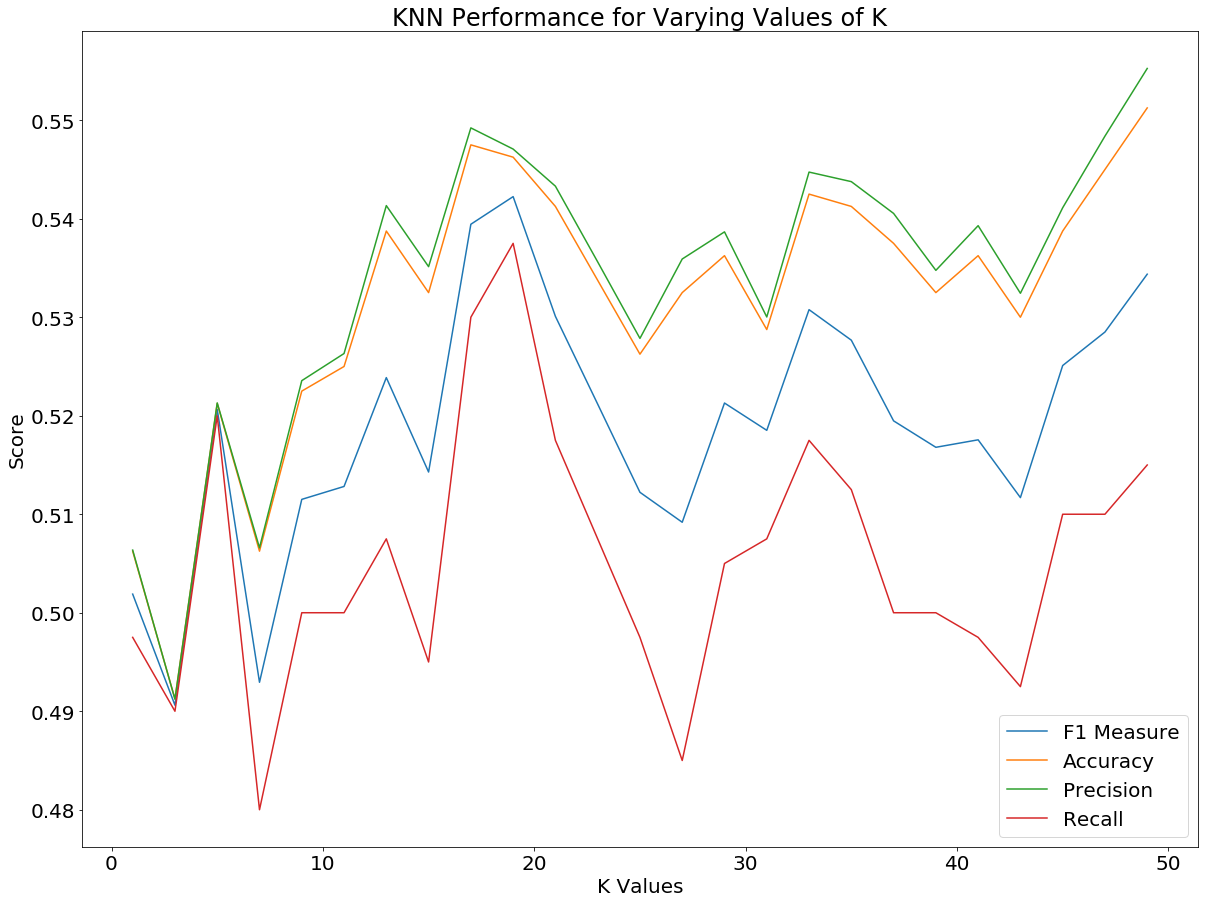

In [17]:
plt.plot(k_vals, f1_vals, label="F1 Measure")
plt.plot(k_vals, accuracy_vals, label="Accuracy")
plt.plot(k_vals, precision_vals, label="Precision")
plt.plot(k_vals, recall_vals, label="Recall")
plt.title("KNN Performance for Varying Values of K")
plt.legend(loc="lower right")
plt.xlabel("K Values")
plt.ylabel("Score")
plt.show()